# Primary Notebook

## Local Code Imports - Do not delete

In [1]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

In [2]:
# DO NOT REMOVE This
%reload_ext autoreload

In [3]:
## Uncomment to filter warnings
#import warnings
#warnings.filterwarnings('ignore')

In [13]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py
#from src import make_data as mk
from src import visualize as viz
from src import model as mdl
from src import custom as cm
#from src import pandas_operators as po

#def test_src():
    #mk.test_make_data()
    #viz.test_viz()
    #mdl.test_model()
    #po.test_pandas()

#    return 1

In [15]:
#test_src()

## Code Imports

In [188]:
## Some standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

# Project Overview

# EDA, Data Cleaning & Feature Engineering

In [82]:
user_factors = pd.read_csv('../data/processed/user_factors.csv')

In [165]:
user_factors_scaled = pd.read_csv('../data/processed/user_factors_scaled.csv')

# AWS KMeans Evaluation

In [42]:
error = [8113978.666767631, 7354872.282449911, 6779693.947846839, 6494419.943265818, 6161394.18380805, 5969178.495847053, 5775171.418613084, 5586181.465087898, 5459016.548945165, 5320932.3011912545, 5191293.46220535, 5090035.762150701, 4986521.909023397, 4919589.194313965, 4845781.722909153, 4738299.132215889, 4697877.381008717, 4626969.254411039, 4562072.290577676, 4519194.064635965, 4451951.002486911, 4413293.651221422, 4361910.62076177, 4339251.383448499, 4277987.088258287, 4244595.896973764, 4199613.235502976, 4156505.1574725825, 4131992.707043184, 4095312.234922758, 4069049.097594653, 4033434.5349058285, 4011851.7686528624, 3976083.217075855, 3949592.2147446494, 3938039.9457209697, 3899577.4734264542, 3881519.333619226, 3850186.2378393123, 3823198.4054184584, 3808773.2587171667, 3784495.988544207, 3761565.3901316617, 3746975.2839278127, 3723729.6121418993, 3699745.0362992603, 3680091.71095213, 3667951.1618961715, 3653602.1354131224, 3632124.2721405267, 3608965.8957424895, 3593001.8085261723, 3577712.029614562, 3560315.3167280406, 3552552.115932628, 3532308.4953923486, 3511941.7114949734, 3498429.793736455]

In [43]:
len(error)

58

In [56]:
cluster = list(range(2, 60))

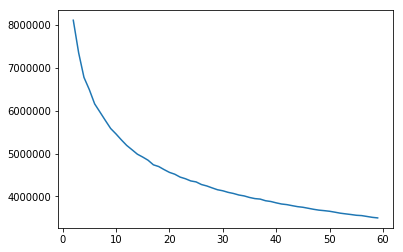

In [51]:
plt.plot(cluster, error);

In [58]:
error_diff = []
for i in list(range(0,56)):
    diff = error[i]-error[i+1]
    error_diff.append(diff)

In [59]:
cluster_diff = list(range(2, len(error_diff)+2))

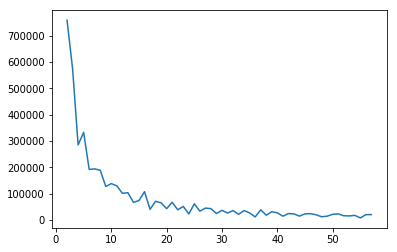

In [60]:
plt.plot(cluster_diff, error_diff);

# KMeans Model

In [190]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 9)

In [191]:
kmeans.fit(user_factors_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [192]:
preds = kmeans.predict(user_factors_scaled)

# Gradient Boosting Machine

In [193]:
preds_df = pd.DataFrame(preds, columns=['cluster'])
user_factors_with_preds = user_factors.copy()
user_factors_with_preds['cluster'] = preds_df
user_factors_with_preds.head()

,id,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,cluster
0,1,-0.380470,0.103641,0.310486,0.078450,0.129363,-0.033363,0.030401,-0.360824,-0.213137,...,-0.480875,0.194733,0.479119,0.328390,-0.123725,-0.188246,-0.525000,-0.133443,-0.167593,4
1,2,-0.226508,0.167774,0.536940,0.235142,-0.036765,0.118235,0.024486,-0.449235,-0.145772,...,-0.314272,0.170148,0.567598,0.492936,-0.072118,-0.063404,-0.715515,0.038176,-0.056638,4
2,3,-0.240955,0.179579,0.439598,0.231143,0.003269,0.110166,0.018843,-0.457156,-0.184155,...,-0.375902,0.142993,0.607431,0.525451,-0.006926,-0.018648,-0.715832,0.011471,-0.136575,4
3,4,-0.271722,0.041331,0.368844,-0.016227,0.102699,0.047941,0.020815,-0.335555,-0.272367,...,-0.530468,0.179969,0.527210,0.440110,0.124539,-0.082171,-0.663929,-0.065500,-0.327186,4
4,5,-0.368851,0.104798,0.349379,0.013516,0.070510,0.036399,-0.017281,-0.401808,-0.266340,...,-0.581576,0.247609,0.590982,0.318466,0.053089,-0.191376,-0.671003,-0.065487,-0.266448,4


In [194]:
len(user_factors_scaled), len(user_factors), len(preds)

(243658, 243658, 243658)

In [195]:
X = user_factors_with_preds.drop(['id', 'cluster'], axis=1)

In [196]:
y = preds

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, shuffle=True)

In [198]:
gbc = GradientBoostingClassifier()
param_grid = {'learning_rate':[.15], 
             'max_depth': [5],
             'min_samples_split': [25],
             'n_estimators': [41],
             'max_features': [7]}
gs_gbc = GridSearchCV(gbc, param_grid, cv=5)
gs_gbc.fit(X_train, y_train)
gbc_train_preds = gs_gbc.predict(X_train)
gbc_test_preds = gs_gbc.predict(X_test)
accuracy_score(y_test, gbc_test_preds), accuracy_score(y_train, gbc_train_preds)

(0.11213986702782566, 0.17308460515587465)

In [199]:
print(confusion_matrix(y_test, gbc_test_preds))
print(confusion_matrix(y_train, gbc_train_preds))

[[ 906  345 1066  583  564  977  855  921  525]
 [ 880  362 1052  663  645 1050  807  831  563]
 [ 868  356 1024  626  630  979  856  904  546]
 [ 891  322 1037  647  587 1065  824  914  545]
 [ 828  315 1055  663  616 1101  834  873  516]
 [ 862  334  976  652  581 1023  852  877  509]
 [ 875  350 1091  669  621  989  780  895  513]
 [ 862  348 1051  657  605  960  797  956  537]
 [ 867  318 1018  622  623 1013  789  909  517]]
[[4026  941 2958 1770 1703 2815 2279 2499 1469]
 [2538 2037 3067 1823 1667 2831 2250 2502 1377]
 [2511  862 4474 1750 1689 2935 2250 2579 1431]
 [2413  882 3005 3137 1633 2810 2282 2565 1514]
 [2488  898 2910 1736 3066 2768 2208 2516 1485]
 [2441  860 2962 1746 1652 4498 2239 2484 1456]
 [2552  919 3025 1797 1655 2823 3742 2509 1442]
 [2520  922 3070 1780 1629 2876 2240 3871 1461]
 [2536  932 3088 1734 1572 2811 2244 2527 2779]]


In [177]:
y.value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [152]:
preds_df['cluster'].value_counts()

12    771330
6     710936
15    688117
14    670582
9     665670
5     665596
2     665459
16    595618
8     583660
3     571562
1     498176
10    491085
13    488026
7     480531
17    463126
11    460582
4     438442
0     325138
Name: cluster, dtype: int64